# Dataset import

In [1]:
# Math and linear algebra
import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
import math
import numpy as np

# Vizualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Utils
import sklearn.metrics as metrics
from sklearn.model_selection import GridSearchCV
from joblib import dump, load
import gc

FLAG_EXPORT = True
FLAG_DEBUG = False
FLAG_LIMIT_N = None #2000

out_path = 'assets_LR2/'

In [2]:
# Import training dataset
raw = pd.read_csv ("../../datasets/brasilia_case_preprocessed.csv", header=0)

raw = raw.drop('timestamp', axis=1)
#raw.tail()

In [3]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84926 entries, 0 to 84925
Data columns (total 13 columns):
temperature      84926 non-null float64
pressure         84926 non-null float64
precipitation    84926 non-null float64
windspeed        84926 non-null float64
voltage          84926 non-null float64
cos_phi          84926 non-null float64
cos_phi_std      84926 non-null float64
month            84926 non-null float64
hour             84926 non-null float64
day_of_week      84926 non-null float64
p3_std           84926 non-null float64
load_factor      84926 non-null float64
p3               84926 non-null float64
dtypes: float64(13)
memory usage: 8.4 MB


In [3]:
from sklearn.model_selection import train_test_split

X = raw.drop('p3', axis=1)
y = raw ['p3']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=200)

if FLAG_LIMIT_N:
    n = FLAG_LIMIT_N
    X_train = X_train[:n]
    X_test = X_test[:n]
    y_train = y_train[:n]
    y_test = y_test[:n]

del X
del y
gc.collect()

10

In [4]:
def regression_report (y_hat, y_test, alpha=0.05, title="Model Evaluation"):
    print ("MAE:                ", metrics.mean_absolute_error(y_test, y_hat))
    print ("RMSE:               ", np.sqrt(metrics.mean_squared_error(y_test, y_hat)))
    print ("Percentual:         ", metrics.mean_absolute_error(y_test,y_hat)/y_test.mean()*100, "%")

    # Previsto vs real
    line = np.arange(np.min([y_test, y_hat]),
                     np.max([y_test, y_hat]),
                     1)

    plt.scatter(y_test,y_hat, Alpha=alpha)
    plt.scatter(line,line, marker='.')
    plt.grid(True)
    plt.title(title)
    plt.xlabel("Real values")
    plt.ylabel("Predicted values")

In [5]:
from sklearn import metrics
import scipy as sp
import numpy as np
import math
from sklearn import metrics

def perturbation_rank(model, x, y, names, regression):
    errors = []

    for i in range(x.shape[1]):
        hold = np.array(x[:, i])
        np.random.shuffle(x[:, i])
        
        if regression:
            pred = model.predict(x)
            error = metrics.mean_absolute_error(y, pred)
        else:
            pred = model.predict_proba(x)
            error = metrics.log_loss(y, pred)
            
        errors.append(error)
        x[:, i] = hold
        
    max_error = np.max(errors)
    importance = [e/max_error for e in errors]

    data = {'name':names,'error':errors,'importance':importance}
    result = pd.DataFrame(data, columns = ['name','error','importance'])
    result.sort_values(by=['importance'], ascending=[0], inplace=True)
    result.reset_index(inplace=True, drop=True)
    return result

# Ridge (Linear model)
* To 85k points, it runs in 1 min

In [6]:
from sklearn.linear_model import Ridge

model1 = Ridge()#LinearRegression()
model1.fit (X_train, y_train)
#pd.DataFrame(model0.coef_,X_train.columns,columns=['Coefficient'])

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

MAE:                 52.63933855026445
RMSE:                69.69656437446467
Percentual:          28.801976559404007 %


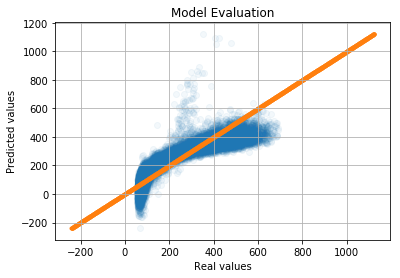

In [7]:
y_hat = model1.predict(X_test)
regression_report (y_hat, y_test)
if FLAG_EXPORT:
    plt.savefig(out_path + 'graph_error_1.svg', format='svg', dpi=1200)
    with open(out_path + 'model1.joblib', 'wb') as file: dump(model1, file)


# Extremey randomized trees
* To 85k points, it runs in 1 min

In [8]:
from sklearn.ensemble import ExtraTreesRegressor

In [9]:
if FLAG_DEBUG:
    mae1 = {}
    mae2 = {}
    for k in range(1,25, 2):
        model = ExtraTreesRegressor(max_depth=k, 
                                    n_estimators=200, 
                                    bootstrap=True, 
                                    max_samples=0.9).fit(X_train,y_train)
        y_hat = model.predict(X_train)
        mae1[k] = metrics.mean_absolute_error(y_train,y_hat)
        y_hat = model.predict(X_test)
        mae2[k] = metrics.mean_absolute_error(y_test,y_hat)

    plt.figure()
    plt.plot(list(mae1.keys()), list(mae1.values()), label='Training dataset error')
    plt.plot(list(mae2.keys()), list(mae2.values()), label='Validation dataset error')
    plt.legend(loc='lower left')
    plt.xlabel("Maximun height")
    plt.ylabel("MAE")
    plt.grid(True)

In [10]:
if FLAG_DEBUG:
    mae1 = {}
    mae2 = {}
    for k in np.arange(1, 30, 1):
        model = ExtraTreesRegressor(max_depth=k,
                                    n_estimators=300, 
                                    bootstrap=True,
                                    max_samples=0.7).fit(X_train,y_train)
        y_hat = model.predict(X_train)
        mae1[k] = metrics.mean_absolute_error(y_train,y_hat)
        y_hat = model.predict(X_test)
        mae2[k] = metrics.mean_absolute_error(y_test,y_hat)

    plt.figure()
    plt.plot(list(mae1.keys()), list(mae1.values()), label='Training dataset error')
    plt.plot(list(mae2.keys()), list(mae2.values()), label='Validation dataset error')
    plt.legend(loc='lower left')
    plt.xlabel("Maximun height")
    plt.ylabel("MAE")
    plt.grid(True)
    plt.savefig(out_path + 'graph_training_extra1.svg', format='svg', dpi=1200)

In [11]:
if FLAG_DEBUG:
    mae1 = {}
    mae2 = {}
    for k in np.arange(0.5, 0.7, 0.02):
        model = ExtraTreesRegressor(max_depth=25, n_estimators=600, bootstrap=True, max_samples=k).fit(X_train,y_train)
        y_hat = model.predict(X_train)
        mae1[k] = metrics.mean_absolute_error(y_train,y_hat)
        y_hat = model.predict(X_test)
        mae2[k] = metrics.mean_absolute_error(y_test,y_hat)

    plt.figure()
    plt.plot(list(mae1.keys()), list(mae1.values()), label='Training dataset error')
    plt.plot(list(mae2.keys()), list(mae2.values()), label='Validation dataset error')
    plt.legend(loc='lower left')
    plt.xlabel("Maximun height")
    plt.ylabel("MAE")
    plt.grid(True)

In [12]:
if FLAG_DEBUG:
    mae1 = {}
    mae2 = {}
    for k in np.arange(2, 30, 1):
        model = ExtraTreesRegressor(min_samples_split=k,
                                    n_estimators=300,
                                    bootstrap=True,
                                    max_samples=0.7).fit(X_train,y_train)
        y_hat = model.predict(X_train)
        mae1[k] = metrics.mean_absolute_error(y_train,y_hat)
        y_hat = model.predict(X_test)
        mae2[k] = metrics.mean_absolute_error(y_test,y_hat)

    plt.figure()
    plt.plot(list(mae1.keys()), list(mae1.values()), label='Training dataset error')
    plt.plot(list(mae2.keys()), list(mae2.values()), label='Validation dataset error')
    plt.legend(loc='lower left')
    plt.xlabel("Min samples per split")
    plt.ylabel("MAE")
    plt.grid(True)
    plt.savefig(out_path + 'graph_training_extra2.svg', format='svg', dpi=1200)

MAE:                 10.085271119916975
RMSE:                18.63758695770727
Percentual:          5.5182255398918505 %


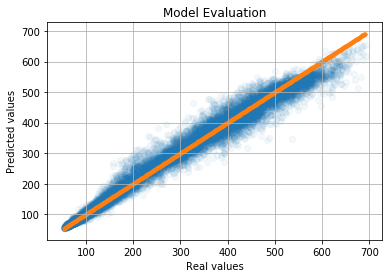

In [13]:
model2 = ExtraTreesRegressor(max_depth=25,
                             n_estimators=400,
                             #max_features=(int)(X_train.shape[1]*k),
                             bootstrap=True,
                             max_samples=0.7)
model2.fit(X_train,y_train)

# TEST
y_hat = model2.predict(X_test)
regression_report (y_hat, y_test)
if FLAG_EXPORT: 
    plt.savefig(out_path + 'graph_error_2.svg', format='svg', dpi=1200)
    with open(out_path + 'model2.joblib', 'wb') as file: dump(model2, file)

# Random Forest
* To 85k points, it runs in 5 min

In [14]:
from sklearn.ensemble import RandomForestRegressor

In [15]:
if FLAG_DEBUG:
    mae1 = {}
    mae2 = {}
    for k in np.arange(2, 10, 1):
        model = RandomForestRegressor(min_samples_split=k, 
                                    n_estimators=100, 
                                    bootstrap=True,
                                    max_samples=0.7).fit(X_train,y_train)
        y_hat = model.predict(X_train)
        mae1[k] = metrics.mean_absolute_error(y_train,y_hat)
        y_hat = model.predict(X_test)
        mae2[k] = metrics.mean_absolute_error(y_test,y_hat)

    plt.figure()
    plt.plot(list(mae1.keys()), list(mae1.values()), label='Training dataset error')
    plt.plot(list(mae2.keys()), list(mae2.values()), label='Validation dataset error')
    plt.legend(loc='lower left')
    plt.xlabel("Maximun height")
    plt.ylabel("MAE")
    plt.grid(True)

In [16]:
if FLAG_DEBUG:
    mae1 = {}
    mae2 = {}
    for k in np.arange(1, 30, 2):
        model = RandomForestRegressor(max_depth=k, 
                                    n_estimators=100, 
                                    bootstrap=True,
                                    max_samples=0.7).fit(X_train,y_train)
        y_hat = model.predict(X_train)
        mae1[k] = metrics.mean_absolute_error(y_train,y_hat)
        y_hat = model.predict(X_test)
        mae2[k] = metrics.mean_absolute_error(y_test,y_hat)

    plt.figure()
    plt.plot(list(mae1.keys()), list(mae1.values()), label='Training dataset error')
    plt.plot(list(mae2.keys()), list(mae2.values()), label='Validation dataset error')
    plt.legend(loc='lower left')
    plt.xlabel("Maximun height")
    plt.ylabel("MAE")
    plt.grid(True)

In [17]:
if FLAG_DEBUG:
    mae1 = {}
    mae2 = {}
    for k in np.arange(.6, 1.0, .02):
        model = RandomForestRegressor(max_depth=20, 
                                    n_estimators=100, 
                                    bootstrap=True,
                                    max_samples=k).fit(X_train,y_train)
        y_hat = model.predict(X_train)
        mae1[k] = metrics.mean_absolute_error(y_train,y_hat)
        y_hat = model.predict(X_test)
        mae2[k] = metrics.mean_absolute_error(y_test,y_hat)

    plt.figure()
    plt.plot(list(mae1.keys()), list(mae1.values()), label='Training dataset error')
    plt.plot(list(mae2.keys()), list(mae2.values()), label='Validation dataset error')
    plt.legend(loc='lower left')
    plt.xlabel("Maximun height")
    plt.ylabel("MAE")
    plt.grid(True)

MAE:                 9.803247310196125
RMSE:                18.486435687112024
Percentual:          5.363914270402448 %


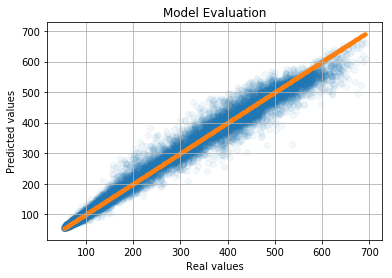

In [18]:
# Train
model3 = RandomForestRegressor(max_depth=20, n_estimators=400, max_features=0.9)
model3.fit(X_train,y_train)

# TEST
y_hat = model3.predict(X_test)
regression_report (y_hat, y_test)
if FLAG_EXPORT: 
    plt.savefig(out_path + 'graph_error_3.svg', format='svg', dpi=1200)
    with open(out_path + 'model3.joblib', 'wb') as file: dump(model3, file)

# Gradient boosting machines
* To 85k points, it runs in 4 min

In [19]:
from sklearn.ensemble import GradientBoostingRegressor

In [20]:
if FLAG_DEBUG:
    mae1 = {}
    mae2 = {}
    for k in np.arange(7, 12, 1):
        model = GradientBoostingRegressor(max_depth=k,
                                          loss='ls',
                                        n_estimators=400).fit(X_train,y_train)
        y_hat = model.predict(X_train)
        mae1[k] = metrics.mean_absolute_error(y_train,y_hat)
        y_hat = model.predict(X_test)
        mae2[k] = metrics.mean_absolute_error(y_test,y_hat)

    plt.figure()
    plt.plot(list(mae1.keys()), list(mae1.values()), label='Training dataset error')
    plt.plot(list(mae2.keys()), list(mae2.values()), label='Validation dataset error')
    plt.legend(loc='lower left')
    plt.xlabel("Maximun height")
    plt.ylabel("MAE")
    plt.grid(True)

In [21]:
if FLAG_DEBUG:
    nfolds = 2
    param_grid = {
        'loss': ['ls', 'lad', 'huber', 'quantile']
    }
    grid_search = GridSearchCV(
        GradientBoostingRegressor (max_depth=13),
        param_grid,
        cv=nfolds,
        verbose=0
    )
    grid_search.fit(X_train, y_train)
    grid_search.best_params_

MAE:                 10.335982749523918
RMSE:                18.760078495028985
Percentual:          5.655404134417957 %


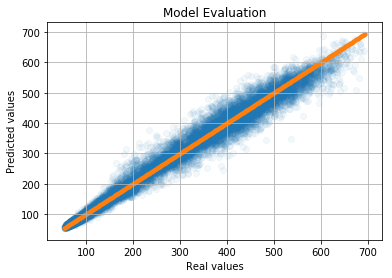

In [22]:
model4 = GradientBoostingRegressor(max_depth=8,
                                   loss='ls',
                                  n_estimators=400)
model4.fit(X_train,y_train)

# TEST
y_hat = model4.predict(X_test)
regression_report (y_hat, y_test)
if FLAG_EXPORT: 
    plt.savefig(out_path + 'graph_error_4.svg', format='svg', dpi=1200)
    with open(out_path + 'model4.joblib', 'wb') as file: dump(model4, file)

# SVM
* To 85k points, it runs in 2hs 26min
* C defaut:1.  The strength of the regularization is inversely proportional to C
* gamma default = scale = 1 / (n_features * X.var())

In [23]:
from sklearn.svm import SVR

In [24]:
if FLAG_DEBUG:
    mae1 = {}
    mae2 = {}
    for k in np.arange(0.7, 0.9, 0.1):
        model = SVR(kernel='rbf',
                C=800,
                degree= 3,
                epsilon=k,
                gamma='scale',    
                cache_size=1000).fit(X_train,y_train)
        y_hat = model.predict(X_train)
        mae1[k] = metrics.mean_absolute_error(y_train,y_hat)
        y_hat = model.predict(X_test)
        mae2[k] = metrics.mean_absolute_error(y_test,y_hat)

    plt.figure()
    #plt.plot(list(mae1.keys()), list(mae1.values()), label='Training dataset error')
    plt.plot(list(mae2.keys()), list(mae2.values()), label='Validation dataset error')
    plt.legend(loc='lower left')
    plt.xlabel("Maximun height")
    plt.ylabel("MAE")
    plt.grid(True)#15.42880

In [25]:
def svm_param_selection(X, y, nfolds):
    param_grid = {
        'C': [800], 
        'epsilon' : [0.4, 0.5, 0.6], 
        'kernel':['rbf']
    }
    grid_search = GridSearchCV(
        SVR(cache_size=1000),
        param_grid,
        cv=nfolds,
        verbose=2
    )
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

if FLAG_DEBUG:
    res = svm_param_selection(X,y, 2)
    res

MAE:                 12.491254781017746
RMSE:                23.016145257042194
Percentual:          6.834676067535978 %


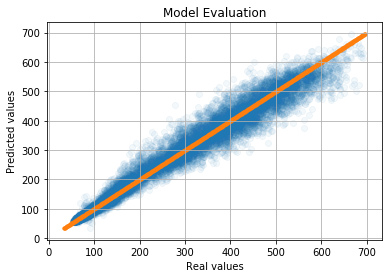

In [26]:
model5 = SVR(kernel='rbf',
            C=900,
            epsilon=1,
            gamma='scale',    
            cache_size=1000)
model5.fit(X_train, y_train)


y_hat = model5.predict(X_test)
regression_report (y_hat, y_test)
if FLAG_EXPORT: 
    plt.savefig(out_path + 'graph_error_5.svg', format='svg', dpi=1200)
    with open(out_path + 'model5.joblib', 'wb') as file: dump(model5, file)

# ANN
* To 85k points, it runs in 7 min
* We wrap the model to allow compatibility with Scikitlearn

In [27]:
import keras
from keras import Sequential
from keras.layers import Dropout, Dense
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

#utils
from keras_tqdm import TQDMNotebookCallback
from keras.models import save_model, load_model
from keras.utils.vis_utils import plot_model

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

W1230 05:56:14.910160 140678515992384 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1230 05:56:15.370847 140678515992384 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1230 05:56:15.488559 140678515992384 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1230 05:56:15.549124 140678515992384 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W1230 05:56:15.558677 


Epoch 00001: val_mean_absolute_error improved from inf to 18.88482, saving model to assets_LR2/model6.h5



Epoch 00002: val_mean_absolute_error improved from 18.88482 to 17.26084, saving model to assets_LR2/model6.h5



Epoch 00003: val_mean_absolute_error improved from 17.26084 to 16.03180, saving model to assets_LR2/model6.h5



Epoch 00004: val_mean_absolute_error did not improve from 16.03180



Epoch 00005: val_mean_absolute_error did not improve from 16.03180



Epoch 00006: val_mean_absolute_error did not improve from 16.03180



Epoch 00007: val_mean_absolute_error improved from 16.03180 to 15.48135, saving model to assets_LR2/model6.h5



Epoch 00008: val_mean_absolute_error improved from 15.48135 to 15.38885, saving model to assets_LR2/model6.h5



Epoch 00009: val_mean_absolute_error did not improve from 15.38885



Epoch 00010: val_mean_absolute_error did not improve from 15.38885



Epoch 00011: val_mean_absolute_error did not improve from 15.38885



Epoch 00012: val_mean_absolute_error did not improve from 15.38885



Epoch 00013: val_mean_absolute_error did not improve from 15.38885



Epoch 00014: val_mean_absolute_error improved from 15.38885 to 14.62065, saving model to assets_LR2/model6.h5



Epoch 00015: val_mean_absolute_error did not improve from 14.62065



Epoch 00016: val_mean_absolute_error did not improve from 14.62065



Epoch 00017: val_mean_absolute_error did not improve from 14.62065



Epoch 00018: val_mean_absolute_error did not improve from 14.62065



Epoch 00019: val_mean_absolute_error improved from 14.62065 to 14.44120, saving model to assets_LR2/model6.h5



Epoch 00020: val_mean_absolute_error did not improve from 14.44120



Epoch 00021: val_mean_absolute_error did not improve from 14.44120



Epoch 00022: val_mean_absolute_error did not improve from 14.44120



Epoch 00023: val_mean_absolute_error did not improve from 14.44120



Epoch 00024: val_mean_absolute_error did not improve from 14.44120



Epoch 00025: val_mean_absolute_error did not improve from 14.44120



Epoch 00026: val_mean_absolute_error improved from 14.44120 to 14.35637, saving model to assets_LR2/model6.h5



Epoch 00027: val_mean_absolute_error did not improve from 14.35637



Epoch 00028: val_mean_absolute_error did not improve from 14.35637



Epoch 00029: val_mean_absolute_error did not improve from 14.35637



Epoch 00030: val_mean_absolute_error did not improve from 14.35637



Epoch 00031: val_mean_absolute_error did not improve from 14.35637



Epoch 00032: val_mean_absolute_error did not improve from 14.35637



Epoch 00033: val_mean_absolute_error did not improve from 14.35637



Epoch 00034: val_mean_absolute_error did not improve from 14.35637



Epoch 00035: val_mean_absolute_error did not improve from 14.35637



Epoch 00036: val_mean_absolute_error did not improve from 14.35637



Epoch 00037: val_mean_absolute_error did not improve from 14.35637



Epoch 00038: val_mean_absolute_error did not improve from 14.35637



Epoch 00039: val_mean_absolute_error did not improve from 14.35637



Epoch 00040: val_mean_absolute_error did not improve from 14.35637



Epoch 00041: val_mean_absolute_error improved from 14.35637 to 14.13230, saving model to assets_LR2/model6.h5



Epoch 00042: val_mean_absolute_error did not improve from 14.13230



Epoch 00043: val_mean_absolute_error did not improve from 14.13230



Epoch 00044: val_mean_absolute_error did not improve from 14.13230



Epoch 00045: val_mean_absolute_error did not improve from 14.13230



Epoch 00046: val_mean_absolute_error did not improve from 14.13230



Epoch 00047: val_mean_absolute_error did not improve from 14.13230



Epoch 00048: val_mean_absolute_error did not improve from 14.13230



Epoch 00049: val_mean_absolute_error did not improve from 14.13230



Epoch 00050: val_mean_absolute_error did not improve from 14.13230



Epoch 00051: val_mean_absolute_error improved from 14.13230 to 13.86936, saving model to assets_LR2/model6.h5



Epoch 00052: val_mean_absolute_error did not improve from 13.86936



Epoch 00053: val_mean_absolute_error did not improve from 13.86936



Epoch 00054: val_mean_absolute_error did not improve from 13.86936



Epoch 00055: val_mean_absolute_error did not improve from 13.86936



Epoch 00056: val_mean_absolute_error did not improve from 13.86936



Epoch 00057: val_mean_absolute_error did not improve from 13.86936



Epoch 00058: val_mean_absolute_error did not improve from 13.86936



Epoch 00059: val_mean_absolute_error did not improve from 13.86936



Epoch 00060: val_mean_absolute_error did not improve from 13.86936



Epoch 00061: val_mean_absolute_error did not improve from 13.86936



Epoch 00062: val_mean_absolute_error did not improve from 13.86936



Epoch 00063: val_mean_absolute_error did not improve from 13.86936



Epoch 00064: val_mean_absolute_error improved from 13.86936 to 13.79617, saving model to assets_LR2/model6.h5



Epoch 00065: val_mean_absolute_error did not improve from 13.79617



Epoch 00066: val_mean_absolute_error did not improve from 13.79617



Epoch 00067: val_mean_absolute_error did not improve from 13.79617



Epoch 00068: val_mean_absolute_error did not improve from 13.79617



Epoch 00069: val_mean_absolute_error did not improve from 13.79617



Epoch 00070: val_mean_absolute_error did not improve from 13.79617



Epoch 00071: val_mean_absolute_error did not improve from 13.79617



Epoch 00072: val_mean_absolute_error did not improve from 13.79617



Epoch 00073: val_mean_absolute_error did not improve from 13.79617



Epoch 00074: val_mean_absolute_error did not improve from 13.79617



Epoch 00075: val_mean_absolute_error did not improve from 13.79617



Epoch 00076: val_mean_absolute_error did not improve from 13.79617



Epoch 00077: val_mean_absolute_error improved from 13.79617 to 13.64244, saving model to assets_LR2/model6.h5



Epoch 00078: val_mean_absolute_error did not improve from 13.64244



Epoch 00079: val_mean_absolute_error did not improve from 13.64244



Epoch 00080: val_mean_absolute_error did not improve from 13.64244



Epoch 00081: val_mean_absolute_error did not improve from 13.64244



Epoch 00082: val_mean_absolute_error did not improve from 13.64244



Epoch 00083: val_mean_absolute_error did not improve from 13.64244



Epoch 00084: val_mean_absolute_error did not improve from 13.64244



Epoch 00085: val_mean_absolute_error did not improve from 13.64244



Epoch 00086: val_mean_absolute_error did not improve from 13.64244



Epoch 00087: val_mean_absolute_error improved from 13.64244 to 13.61046, saving model to assets_LR2/model6.h5



Epoch 00088: val_mean_absolute_error did not improve from 13.61046



Epoch 00089: val_mean_absolute_error did not improve from 13.61046



Epoch 00090: val_mean_absolute_error did not improve from 13.61046



Epoch 00091: val_mean_absolute_error did not improve from 13.61046



Epoch 00092: val_mean_absolute_error did not improve from 13.61046



Epoch 00093: val_mean_absolute_error did not improve from 13.61046



Epoch 00094: val_mean_absolute_error did not improve from 13.61046



Epoch 00095: val_mean_absolute_error did not improve from 13.61046



Epoch 00096: val_mean_absolute_error improved from 13.61046 to 13.60671, saving model to assets_LR2/model6.h5



Epoch 00097: val_mean_absolute_error improved from 13.60671 to 13.53021, saving model to assets_LR2/model6.h5



Epoch 00098: val_mean_absolute_error did not improve from 13.53021



Epoch 00099: val_mean_absolute_error did not improve from 13.53021



Epoch 00100: val_mean_absolute_error improved from 13.53021 to 13.32291, saving model to assets_LR2/model6.h5



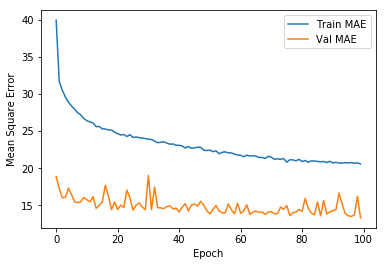

In [28]:
# create a function that returns a model, taking as parameters things you
# want to verify using cross-valdiation and model selection
def create_model():
    model = Sequential()
    model.add(Dense(100,activation='relu', input_dim=X_train.shape[1]))
    model.add(Dropout(0.2))
    model.add(Dense(100,activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(40,activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(20,activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='linear'))
    
    model.compile(loss='mae',optimizer='adam', metrics=['mae'])

    return model

# wrap the model using the function you created
model6 = create_model()#KerasRegressor(build_fn=create_model,verbose=0)
model_save_path = out_path + 'model6.h5'
# train
callback_es = EarlyStopping(monitor='val_mean_absolute_error', mode='min', verbose=1, patience=50)
callback_cp = ModelCheckpoint(model_save_path, monitor='val_mean_absolute_error', mode='min', verbose=1, save_best_only=True)

history = model6.fit(X_train, 
                     y_train, 
                     epochs=100, 
                     verbose=0, 
                     batch_size=16, 
                     validation_split = 0.1,
                    callbacks=[TQDMNotebookCallback(), callback_es, callback_cp])

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Mean Square Error')
plt.plot(hist['epoch'], hist['mean_absolute_error'], label='Train MAE')
plt.plot(hist['epoch'], hist['val_mean_absolute_error'], label = 'Val MAE')
plt.legend()
#plt.ylim([0,50])

MAE:                 12.988141225313692
RMSE:                22.81351202866829
Percentual:          7.106550907065577 %


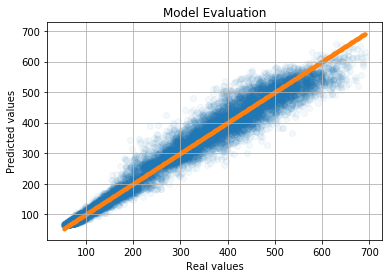

In [29]:
model6 = load_model(model_save_path)
y_hat = model6.predict(X_test)#[:, 0]
regression_report (y_hat.reshape(len(y_hat)), y_test)
if FLAG_EXPORT: 
    plt.savefig(out_path + 'graph_error_6.svg', format='svg', dpi=1200)
    
    
 #   with open(out_path + 'ANN_model_summary.txt', 'w') as file: 
 #       model6.summary(print_fn=lambda line: file.write(line+'\n'))
#    plot_model(model6, to_file=(out_path+'ANN_model_plot.png'), 
#           show_shapes=True, 
#           show_layer_names=True)

# Ensemble
* To 85k points, it runs in 28min

In [30]:
from stacker import Stacker
from sklearn.ensemble import ExtraTreesRegressor
from keras.models import save_model, load_model
from joblib import dump, load
from sklearn.ensemble import RandomForestRegressor

In [31]:
with open(out_path + 'model1.joblib', 'rb') as file: model1 = load(file)
with open(out_path + 'model2.joblib', 'rb') as file: model2 = load(file)
with open(out_path + 'model3.joblib', 'rb') as file: model3 = load(file)
with open(out_path + 'model4.joblib', 'rb') as file: model4 = load(file)
with open(out_path + 'model5.joblib', 'rb') as file: model5 = load(file)
model6 = load_model(out_path+'model6.h5')

estimators = [
    ('LR', model1),
    ('Extra', model2),
    ('RF', model3),
    ('GBT', model4),
    ('SVM', model5),
    ('ANN', model6)
]


In [32]:
if FLAG_DEBUG:
    mae1 = {}
    mae2 = {}
    for k in np.arange(18, 23, 2):
        model = Stacker (estimators, RandomForestRegressor(max_depth=k, 
                                                            n_estimators=600, 
                                                            max_samples=0.6, 
                                                            max_features=0.6), propagate_input=True)
        model.fit(X_train.values, y_train.values)
        y_hat = model.predict(X_train)
        mae1[k] = metrics.mean_absolute_error(y_train,y_hat)
        y_hat = model.predict(X_test)
        mae2[k] = metrics.mean_absolute_error(y_test,y_hat)
        print('.', end='')

    print(mae2)
    plt.figure()
    #plt.plot(list(mae1.keys()), list(mae1.values()), label='Training dataset error')
    plt.plot(list(mae2.keys()), list(mae2.values()), label='Validation dataset error')
    plt.legend(loc='lower left')
    plt.xlabel("Maximun height")
    plt.ylabel("MAE")
    plt.grid(True)

In [33]:
model_L1 = RandomForestRegressor(max_depth=25, 
                                n_estimators=400, 
                                max_samples=0.6, 
                                max_features=0.6)
model_ensembled = Stacker (estimators, model_L1, propagate_input=True)
model_ensembled.fit(X_train.values, y_train.values)
pd.DataFrame(model_ensembled.get_L0_dataset())

del X_train
del y_train
gc.collect()
#with open(out_path + 'model_ensembled.joblib', 'rb') as file: model_ensembled = load(file)
predictions = model_ensembled.predict_all(X_test)

In [34]:
errors = []
for y_hat in predictions:
    mae = abs(y_test - y_hat).sum()/len(y_test)
    rmse = math.sqrt(((y_test - y_hat)*(y_test - y_hat)).sum()/len(y_test))
    perc = mae/y_test.mean()*100
    errors.append([mae, rmse, perc])
errors = pd.DataFrame(errors, 
                   index=([name for name, model in estimators] + ['Ens.']),
                   columns=['MAE', 'RMSE', 'Percentual'])
if FLAG_EXPORT: errors.to_latex(out_path+'table_errors.tex')
errors

,MAE,RMSE,Percentual
LR,52.639339,69.696564,28.801977
Extra,10.085271,18.637587,5.518226
RF,9.803247,18.486436,5.363914
GBT,10.335983,18.760078,5.655404
SVM,12.491255,23.016145,6.834676
ANN,12.988141,22.813512,7.106551
Ens.,9.325708,17.667483,5.102626


In [35]:
if FLAG_EXPORT: errors.to_latex(out_path+'table_errors.tex')
errors

,MAE,RMSE,Percentual
LR,52.639339,69.696564,28.801977
Extra,10.085271,18.637587,5.518226
RF,9.803247,18.486436,5.363914
GBT,10.335983,18.760078,5.655404
SVM,12.491255,23.016145,6.834676
ANN,12.988141,22.813512,7.106551
Ens.,9.325708,17.667483,5.102626


In [36]:
## Evaluate feature's importance/error (given by Input Perturbation Method)
perturbations = perturbation_rank(model_ensembled, X_test.values, y_test.values, X_test.columns, True).drop('importance', axis=1)
for model in [model for name, model in estimators]:
    perturbation = perturbation_rank(model, X_test.values, y_test.values, X_test.columns, True).drop('importance', axis=1)
    perturbations = pd.merge(perturbations,
                             perturbation,
                             on='name')

perturbations.columns = (['model', 'Ens.'] + [name for name, model in estimators])
perturbations = pd.merge(perturbations,
                         pd.DataFrame(np.array([np.array(X_test.columns), model1.coef_]).transpose(), columns =['model', 'LR Coeff.']),
                         on='model')

perturbations = perturbations.set_index(perturbations.model)
perturbations = perturbations.drop ('model', axis=1)
#perturbations = perturbations[['LR', 'RF', 'SVM', 'ANN', 'Ens.', 'LR Coeff.']]

if FLAG_EXPORT: perturbations.to_latex(out_path+'table_perturbations.tex')
perturbations

,Ens.,LR,Extra,RF,GBT,SVM,ANN,LR Coeff.
model,,,,,,,,
cos_phi,104.425484,85.106176,96.896243,107.515866,99.892267,74.892855,77.655180,59.1096
hour,25.666264,55.566433,31.327811,25.693496,25.725546,35.223057,40.606448,-15.0641
temperature,23.510341,60.983073,23.940795,23.631828,24.459754,27.932997,25.342514,29.0627
month,22.456596,52.838672,20.808406,22.747293,20.954211,20.490954,18.274293,-4.20456
p3_std,14.918092,92.665140,17.136623,14.204756,21.159527,39.498430,43.576466,72.4925
pressure,13.283658,53.867648,13.279600,14.277442,12.709062,17.678286,15.532876,9.51221
load_factor,13.081279,77.878529,14.215470,13.124130,18.442769,29.652245,30.870723,56.8198
voltage,12.105295,52.638030,12.123465,12.601718,12.820989,16.245706,14.823288,-0.0432593
cos_phi_std,11.800656,53.303106,16.669218,11.955112,13.616144,27.494944,26.356878,5.17373


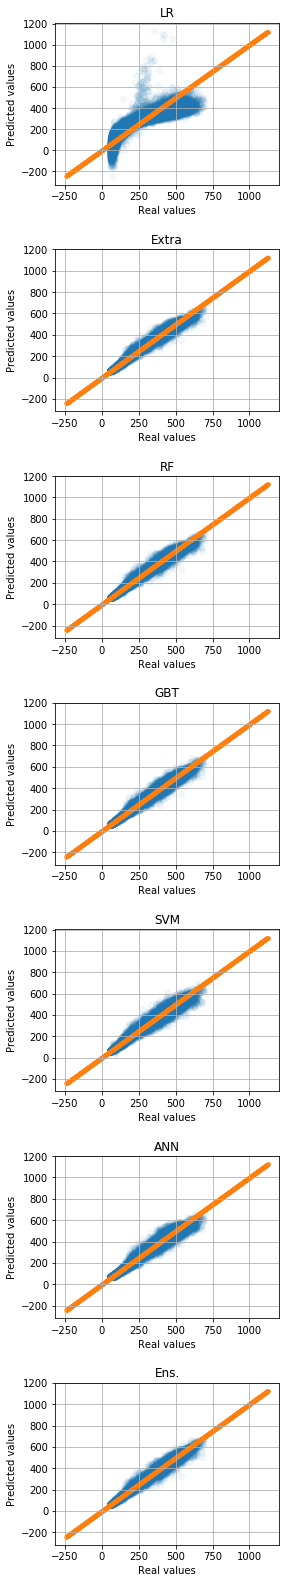

In [37]:
# Evaluate errors graphcally
l = len(predictions)
line = np.arange(min ([min (y_test), np.min(predictions)]),
                 max ([max (y_test), np.max(predictions)]),
                 1)

fig, axes = plt.subplots(l, 1, figsize=(4, 4*l))
plt.subplots_adjust(hspace = .4)
for i in range(l):
    axes[i].scatter(y_test, predictions[i], Alpha=0.05)
    axes[i].scatter(line, line, marker='.')
    
    axes[i].grid(True)
    axes[i].set_title(errors.index[i])
    axes[i].set_xlabel("Real values")
    axes[i].set_ylabel("Predicted values")
if FLAG_EXPORT: 
    plt.savefig(out_path + 'graph_error_ensembled.svg', format='svg', dpi=1200)
    with open(out_path + 'model_ensembled.joblib', 'wb') as file: dump(model_ensembled, file)